### Data

In [10]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:

from sklearn.model_selection import train_test_split
import numpy as np


path = '/content/drive/MyDrive/Final project/'
images = np.load(path + 'images_256.npy')
masks = np.load(path + 'masks_256.npy')

images = images[..., np.newaxis]
masks = masks[..., np.newaxis]

for i in range(images.shape[0]):
  images[i,:, :] = (images[i,:, :] - np.mean(images[i,:, :]))/ np.std(images[i,:, :])


images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=1)


print ("Images_train shape: " + str(images_train.shape))
print ("Masks_train shape: " + str(masks_train.shape))

print ("Images_test shape: " + str(images_test.shape))
print ("Masks_test shape: " + str(masks_test.shape))

Images_train shape: (2451, 256, 256, 1)
Masks_train shape: (2451, 256, 256, 1)
Images_test shape: (613, 256, 256, 1)
Masks_test shape: (613, 256, 256, 1)


In [14]:

from __future__ import absolute_import

import warnings
import numpy as np
import tensorflow as tf
from tensorflow import math
import tensorflow.keras.backend as K
from tensorflow.nn import depth_to_space
from tensorflow.image import extract_patches
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Embedding, Dropout, Conv2D, BatchNormalization, Activation, concatenate, multiply, add
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, Reshape, Flatten
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, ELU, Softmax


In [15]:

def convblock(x, filters, kernel = 3):

    l = Conv2D(filters, kernel, padding='same')(x)
    l = BatchNormalization()(l)
    l = Activation('relu')(l)
    return l


def shiftmlp(x, features, H, W, kernel = 1, drop = 0):

    l = tf.transpose(x, (0, 2, 1, 3))
    l = tf.roll(l, 2, axis=0)
    l = tf.transpose(l, (0, 2, 1, 3))

    l = Conv2D(features, 3, strides=2, padding='same')(l)
    l = Flatten()(l)
    l = Dense(H*W, activation='linear')(l)
    l = Reshape((H, W, 1))(l)

    l = Conv2D(features, kernel, padding='same')(l)
    l = Activation('gelu')(l)
    l = Dropout(drop)(l)

    return l


def shiftedBlock(x, features, H, W, kernel = 1, drop = 0):

    l = LayerNormalization()(x)
    l = shiftmlp(l, features, H, W, kernel, drop)
    l = Activation('gelu')(l)
    return l


def tokMLPBlock(x, features, H, W, kernel = 1, drop = 0):
  
    l1 = shiftedBlock(x, features, H, W, kernel, drop)
    l = Activation('gelu')(l1)
    l = shiftedBlock(l, features, H, W, kernel, drop)
    l = LayerNormalization()(l)
    l2 = Conv2D(features, 3, padding='same')(l)
    l = concatenate([l1, l2])
    return l


inputs = Input(shape = (256, 256 , 1))
# conv stage 1
x = convblock(inputs, 64)
x = MaxPooling2D()(x)
t1 = x
# conv stage 2
x = convblock(x, 128)
x = MaxPooling2D()(x)
t2 = x
# conv state 3
x = convblock(x, 256)
x = MaxPooling2D()(x)
t3 = x
# tok mlp stage 4
x = tokMLPBlock(x, 64, 16, 16, drop=0.25)
t4 = x
# bottleneck
x = tokMLPBlock(x, 128, 8, 8, drop=0.25)
t5 = x
# tok mlp stage 4
x = tokMLPBlock(x, 64, 16, 16, drop=0.25)
x = concatenate([x, t4])

x = Conv2DTranspose(256, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = concatenate([x, t3])
# conv stage 3
x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = concatenate([x, t2])
# conv stage 2
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = concatenate([x, t1])
# conv stage 1
x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(1, 1, padding='same')(x)
out = Activation('sigmoid')(x)


model = Model(inputs, out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [16]:
from tensorflow.keras.losses import binary_crossentropy

smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [17]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'binary_crossentropy', 
              metrics=[dice_coef]) 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

# model checkpoint callback
model_weights_saving_path = "/content/drive/MyDrive/Final project/CustomUNeXt.h5"
checkpoint = ModelCheckpoint(model_weights_saving_path, verbose=1, save_best_only=True, save_weights_only=True, monitor = 'dice_coef', mode='max')


# early stopping after 7 epochs
stop = EarlyStopping(patience=7, monitor='dice_coef', mode='max', verbose=1)

history = model.fit(images_train, masks_train, 
                    epochs = 10, 
                    batch_size = 2,
                    callbacks = [checkpoint, stop], 
                    validation_data = (images_test, masks_test)) 

Epoch 1/10
1226/1226 [==============================] - ETA: 0s - loss: 0.0872 - dice_coef: 0.1554
Epoch 1: dice_coef improved from -inf to 0.15539, saving model to /content/drive/MyDrive/Final project/CustomUNeXt.h5
1226/1226 [==============================] - 702s 568ms/step - loss: 0.0872 - dice_coef: 0.1554 - val_loss: 0.0520 - val_dice_coef: 0.2810
Epoch 2/10
1226/1226 [==============================] - ETA: 0s - loss: 0.0412 - dice_coef: 0.3449
Epoch 2: dice_coef improved from 0.15539 to 0.34491, saving model to /content/drive/MyDrive/Final project/CustomUNeXt.h5
1226/1226 [==============================] - 710s 579ms/step - loss: 0.0412 - dice_coef: 0.3449 - val_loss: 0.0421 - val_dice_coef: 0.3354
Epoch 3/10
1226/1226 [==============================] - ETA: 0s - loss: 0.0319 - dice_coef: 0.4603
Epoch 3: dice_coef improved from 0.34491 to 0.46032, saving model to /content/drive/MyDrive/Final project/CustomUNeXt.h5
1226/1226 [==============================] - 749s 611ms/step - lo

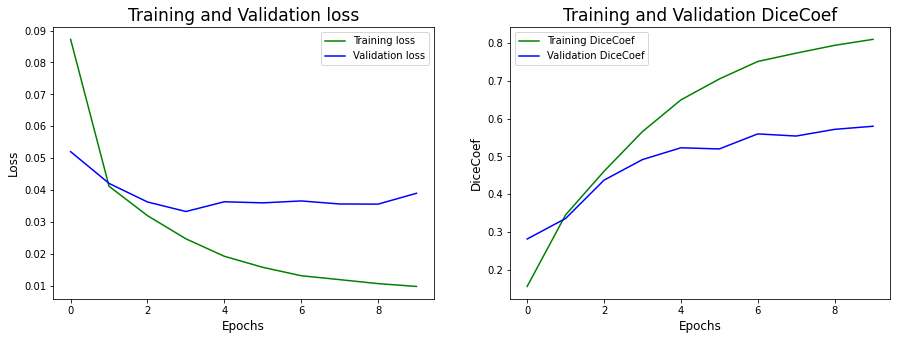

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

epochs = list(range(10))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'g', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epochs', size=12)
plt.ylabel('Loss', size=12)
plt.title('Training and Validation loss', size=17)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['dice_coef'], 'g', label='Training DiceCoef')
plt.plot(epochs, history.history['val_dice_coef'], 'b', label='Validation DiceCoef')
plt.xlabel('Epochs', size=12)
plt.ylabel('DiceCoef', size=12)
plt.title('Training and Validation DiceCoef', size=17)
plt.legend()

plt.show()

In [ ]:
model.load_weights("/content/drive/MyDrive/Final project/CustomUNeXt.h5")
predictions = model.predict(images_train[0:1,:,:,:])

In [ ]:
import matplotlib.pyplot as plt

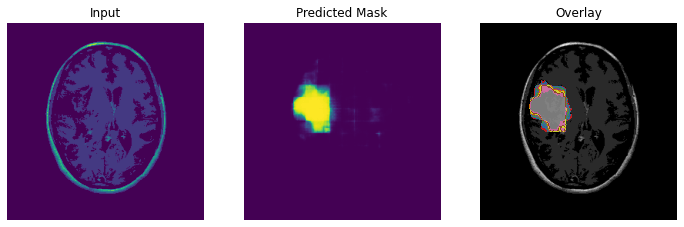

In [ ]:
plt.figure(figsize=(12,10))


# pred
plt.subplot(1,3,1)
plt.title("Input")
plt.imshow(images_train[4,:,:,4])
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(predictions[4,:,:,4])
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Overlay')
plt.imshow(images_train[4,:,:,4], cmap='gray')
mask = np.ma.masked_where(predictions[4,:,:,4] <= 0.1, predictions[4,:,:,4])
plt.imshow(mask, alpha=0.8, cmap='Set1')
plt.axis('off')

plt.show()

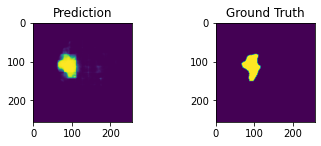

In [ ]:

plt.subplot(221)
plt.title('Prediction')
plt.imshow(predictions[0,:,:,0])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(masks_train[0,:,:,0]) 